In [1]:
# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import pandas as pd
import scipy.io
from statistics import mode
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import pydot
import multiprocessing as mp

eps = 1e-5  # a small number


# Data Processing for Titanic.
from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer

# For Spam Kaggle Competition.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import glob



In [2]:
# Utility function.
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(name + '.csv', index_label='Id')
def split(data, labels, val_size):
    num_items = len(data)
    assert num_items == len(labels)
    assert val_size >= 0
    if val_size < 1.0:
        val_size = int(num_items * val_size)
    train_size = num_items - val_size
    idx = random.permutation(num_items)
    data_train = data[idx][:train_size]
    label_train = labels[idx][:train_size]
    data_val = data[idx][train_size:]
    label_val = labels[idx][train_size:]
    return data_train, data_val, label_train, label_val

def get_vote_result(vote):
    cutoff = len(vote)//2
    if sum(vote) > cutoff:
        return 1
    else:
        return 0

<font size=3.6>**3.1 Implement Decision Tree**

In [23]:
    
def gini_impurity(y):
    # TODO implement gini_impurity function
    labels = np.unique(y)
    total_num = float(len(y))
    gini_sum = 0
        
    for item in labels:
        gini_sum += (sum([1 for i in list(y) if i == item])/total_num)**2
            
    return 1 - gini_sum


def information_gain(X, y, thresh):

    right_index = (X <= thresh)
    left_index = (X > thresh)
    y_right = np.extract(right_index, y)
    y_left = np.extract(left_index, y)
        
    # Number of 
    n_parent = float(len(y))
    n_left = float(len(y_left))
    n_right = float(len(y_right))
    assert n_parent == n_left + n_right, "Wrong split"
        
    I_parent = gini_impurity(y)
    I_children = (n_left/n_parent) * gini_impurity(y_left) + \
                    (n_right/n_parent) * gini_impurity(y_right)
    return I_parent - I_children

In [24]:
class DecisionTree:
    
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # split_rule
        self.data, self.pred = None, None  # for leaf nodes
   

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh): 
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=15)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X, track=False):
        if X.ndim == 1:
            X = np.reshape(X, [1, len(X)])
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            
            if track:
                word = spam_features[self.split_idx]
                if X[:, self.split_idx] < self.thresh:
                    print(word + " < ", self.thresh)
                    yhat[idx0] = self.left.predict(X0, track=track)
                else:
                    print(word + " >= ", self.thresh)
                    yhat[idx1] = self.right.predict(X1, track=track)
            else:
                yhat[idx0] = self.left.predict(X0)
                yhat[idx1] = self.right.predict(X1)

            return yhat
        
    def accuracy(self, X, y):
        yhat = self.predict(X)
        return np.sum(yhat == y) / float(len(y))


<font size=4>**3.2 Implement Random Forests**

In [25]:
class RandomForest():
    
    def __init__(self, num_trees=99, max_depth=5, feature_labels=None):
        self.num_trees = num_trees
        #self.num_sample = num_sample
        self.max_depth = max_depth
        self.feature_labels = feature_labels
        #self.num_feature = None
        
        self.trees = []
        
        for _ in range(num_trees):
            
            num_feature = int(np.sqrt(len(feature_labels)))
            random_feature = np.random.choice(feature_labels, num_feature)
            self.trees.append(DecisionTree(max_depth, random_feature))
    
    def fit(self, X, y, verbose=True):
        num_sample = int(X.shape[0]*(2/3))
        
        pool = mp.Pool()
        results = np.zeros(self.num_trees, dtype=object)
        for i, dt in enumerate(self.trees):
            idx = np.random.choice(range(X.shape[0]), num_sample)
            sub_X = X[idx, :]
            sub_y = y[idx]
            #dt.fit(sub_X, sub_y)
            results[i] = pool.apply_async(dt.fit, args=(sub_X, sub_y))
            if verbose:
                if i%20 == 0:
                    print('%d Tree finish fitting' % i)
        self.trees = [t.get() for t in results]
        pool.close()
        return self
        
    
    def predict(self, X, verbose=True):
        N = X.shape[0]
        pred = np.zeros(N)
        
        for i in range(N):
            votes = np.zeros(self.num_trees)
            for j, dt in enumerate(self.trees):
                votes[j] = dt.predict(X[i, :])
            pred[i] = get_vote_result(votes)
        return pred
    
    def accuracy(self, X, y):
        yhat = self.predict(X)
        return np.sum(yhat == y) / float(len(y))

**Data Processing for Titanic**

In [4]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

In [7]:
path_train = './titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)
path_test = './titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)
y = data[1:, 0]  # label = survived
class_names = ["Died", "Survived"]

labeled_idx = np.where(y != b'')[0]
y = np.array(y[labeled_idx], dtype=np.int)
print("\n\nPart (b): preprocessing the titanic dataset")
X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, 1:]) + onehot_features
titanic_features = features



Part (b): preprocessing the titanic dataset


/Users/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  
/Users/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  after removing the cwd from sys.path.


In [12]:
path_train = './spam_data.mat'
data = scipy.io.loadmat(path_train)
SH_train = data['training_data']
SH_y = np.squeeze(data['training_labels'])
SH_test = data['test_data']
class_names = ["Ham", "Spam"]
spam_features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]

In [13]:
len(SH_test)

5857

In [9]:
random = np.random.RandomState(66)

t_X_train, t_X_val, t_y_train, t_y_val = split(X, y, 0.2)

s_X_train, s_X_val, s_y_train, s_y_val = split(SH_train, SH_y, 0.2)

print(len(t_X_train), len(t_X_val), len(s_X_train), len(s_X_val))

800 199 4138 1034


<font size=4.2> **3.3 Describe Implementation details**

How did you deal with categorical features and missing values?

<font color='blue'>One hot encoding and replace the missing values by mode and mean, depending on the situation. For example, for missing age value, I repalce them by getting the mean value from each pclass.

What was your stopping criterion?

<font color='blue'>The maximum depth.

How did you implement random forests?</font>

<font color='blue'>I build a list to hold the decision trees I need and iterate through all of them.

Did you do anything special to speed up training?</font>

<font color='blue'>Train the trees in parallel by importing multiprocessing library and call mp.Pool and pool.apply_async. The training speed is significantly faster.

Anything else cool you implemented?</font>

<font color='blue'>I have a couple different verbose and track options for debugging and tracking the training process.

<font color='blue'>For Titanic's Kaggle competition, I combined SibSp and Parch to make a new feature.
I also add the length of the ticket to be a new feature.

<font size=4> **3.4 Performance Evaluation**

<font size=3.8> 
I choose random forests with 50 decision trees and 5 max depth. <br><br> Notice that if I change the depth to 15, the training accuracy for decision tree will be much higher(0.95) but the validation accuracy won't be too much higher, indicating overfitting.<br><br>Larger depth and tree numbers could lead more significant different in the validation accuracy.<br><hr>
<font color=blue>**Titanic**</font>:<br><br> **Decision Tree**: &nbsp; &nbsp;&nbsp; train = 0.83, val = 0.798
    <br><br> **Random Forests**: &nbsp;train = 0.83375, val = 0.807<br><br>
<font color=blue>**SPAM**</font>:<br><br> **Decision Tree**:  &nbsp; &nbsp;&nbsp;  train = 0.811, val = 0.807
    <br><br> **Random Forests**: &nbsp;train = 0.819, val = 0.8105

In [29]:
dt = DecisionTree(max_depth=5, feature_labels=titanic_features)
dt.fit(t_X_train, t_y_train)
train_acc = dt.accuracy(t_X_train,  t_y_train)
val_acc = dt.accuracy(t_X_val,  t_y_val)
print("Titanic DT train: ",train_acc, "val:", val_acc)

Titanic DT train:  0.83 val: 0.7989949748743719


In [30]:
dt = DecisionTree(max_depth=5, feature_labels=spam_features)
dt.fit(s_X_train, s_y_train)
train_acc = dt.accuracy(s_X_train,  s_y_train)
val_acc = dt.accuracy(s_X_val,  s_y_val)
print("SPAM DT train: ",train_acc, "val:", val_acc)

SPAM DT train:  0.8115031416143065 val: 0.8075435203094777


In [31]:
rf = RandomForest(num_trees=50, max_depth=5, feature_labels=titanic_features)
rf.fit(t_X_train, t_y_train)
train_acc = rf.accuracy(t_X_train,  t_y_train)
val_acc = rf.accuracy(t_X_val,  t_y_val)
print("Titanic RF train: ",train_acc, "val:", val_acc)

0 Tree finish fitting
20 Tree finish fitting
40 Tree finish fitting
Titanic RF train:  0.83375 val: 0.8140703517587939


In [33]:
rf = RandomForest(num_trees=50, max_depth=5, feature_labels=spam_features)
rf.fit(s_X_train, s_y_train)
train_acc = rf.accuracy(s_X_train,  s_y_train)
val_acc = rf.accuracy(s_X_val,  s_y_val)
print("SPAM RF train: ",train_acc, "val:", val_acc)

0 Tree finish fitting
20 Tree finish fitting
40 Tree finish fitting
SPAM RF train:  0.8195364910584824 val: 0.8105364910584824


<font size=4>**3.5 Generating accuracy**

<font size=3.6>**1. (optional)**<br>
**2. State the split**

exclamation <  1e-05<br>
meter <  1e-05<br>
parenthesis >=  1e-05<br>
dollar <  1e-05<br>
featured <  1e-05<br>
money <  1e-05<br>
Hence the email is a <font color='blue'>ham <font>.

exclamation >=  1e-05<br>
ampersand <  1e-05<br>
meter <  1e-05<br>
volumes <  1e-05<br>
money <  1e-05<br>
dollar <  1e-05<br>
Hence the email is a <font color='red'>spam<font>.

In [12]:
dt = DecisionTree(max_depth=6, feature_labels=spam_features)
dt.fit(s_X_train, s_y_train);
dt.predict(s_X_train[0], track=True)

exclamation <  1e-05
meter <  1e-05
parenthesis >=  1e-05
dollar <  1e-05
featured <  1e-05
money <  1e-05


array([0.])

In [13]:
dt.predict(s_X_train[6], track=True)

exclamation >=  1e-05
ampersand <  1e-05
meter <  1e-05
volumes <  1e-05
money <  1e-05
dollar <  1e-05


array([1.])

<font size=3.6>**3. Plotting the trend**<br>

<font size=3.6> The validation accuracy start to rapidly grow from depth 1-5, and gradually reach the peak value at depth 26, with validation accuracy being 0.825. The best validation point is highlighted on the graph using a red spot.<br>See below for the code and the plot.

In [146]:
import matplotlib.pyplot as plt

depths = [i+1 for i in range(40)]
train_acc_list, val_acc_list = [], []

for i in depths:
    dt = DecisionTree(max_depth=i, feature_labels=spam_features)
    dt.fit(s_X_train, s_y_train)
    train_acc = dt.accuracy(s_X_train,  s_y_train)
    val_acc = dt.accuracy(s_X_val,  s_y_val)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    if i%10 == 0:
        print('done %d'% i)


done 10
done 20
done 30
done 40


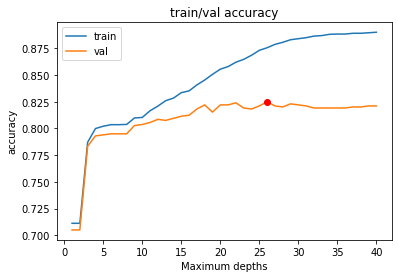

In [150]:
#plt.figure(figsize=(8, 8))
plt.plot(depths, train_acc_list, label='train')
plt.plot(depths, val_acc_list, label='val')

# Get the highest point
ymax = max(val_acc_list)
xpos = val_acc_list.index(ymax)
xmax = depths[xpos]

plt.plot(xmax, ymax, 'ro')
plt.legend(loc='best')
plt.title('train/val accuracy')
plt.xlabel('Maximum depths')
plt.ylabel('accuracy')
plt.show()

In [151]:
print(xmax, ymax)

26 0.8249516441005803


<font size=4>**Kaggle for Titanic using Pandas**

EDA for Titanic data

In [40]:
train = pd.read_csv('./titanic_training.csv')
test = pd.read_csv('./titanic_testing_data.csv')

In [41]:
train.sample(5)

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
432,0.0,3.0,male,NaN,0.0,0.0,349255,7.8958,NaN,C
775,0.0,3.0,male,32.0,0.0,0.0,370376,7.7500,NaN,Q
643,0.0,3.0,male,22.0,0.0,0.0,A/5 21172,7.2500,NaN,S
838,0.0,2.0,male,37.0,1.0,0.0,SC/AH 29037,26.0000,NaN,S
256,0.0,3.0,male,13.0,0.0,2.0,C.A. 2673,20.2500,NaN,S


In [43]:
train['survived'].groupby(train['sex']).mean()

sex
female    0.750716
male      0.190769
Name: survived, dtype: float64

In [48]:
train['ticket_len'] = train['ticket'].apply(lambda x: len(str(x)))
train['ticket_len'].value_counts()

6     448
5     161
4     109
8      85
10     56
7      30
9      28
13     16
17     14
11     14
18     11
15      8
12      8
16      7
3       5
Name: ticket_len, dtype: int64

In [49]:
train['ticket_first'] = train['ticket'].apply(lambda x: str(x)[0])
train.groupby(['ticket_first'])['survived'].mean()

ticket_first
1    0.603550
2    0.456311
3    0.259146
4    0.166667
5    0.000000
6    0.111111
7    0.250000
8    0.000000
9    0.000000
A    0.083333
C    0.358209
F    0.600000
L    0.250000
P    0.617647
S    0.319444
W    0.285714
n         NaN
Name: survived, dtype: float64

In [55]:
sum(train['ticket'].isnull())

1

In [50]:
train['ticket_last'] = train['ticket'].apply(lambda x: str(x)[-1])
train.groupby(['ticket_last'])['survived'].mean()

ticket_last
0    0.414141
1    0.369369
2    0.397959
3    0.388889
4    0.279070
5    0.340426
6    0.438202
7    0.340659
8    0.538462
9    0.340206
E    0.250000
n         NaN
Name: survived, dtype: float64

In [51]:
train.drop(['ticket_last'], inplace=True, axis=1)

In [52]:
train['cabin_first'] = train['cabin'].apply(lambda x: str(x)[0])
train.groupby(['cabin_first'])['survived'].mean()

cabin_first
A    0.500000
B    0.714286
C    0.611111
D    0.682927
E    0.724138
F    0.600000
G    0.750000
T    0.000000
n    0.308290
Name: survived, dtype: float64

In [13]:
# Feature engineering based on
# https://www.kaggle.com/zlatankr/titanic-random-forest-82-78#Ticket

# Based on my own EDA with my own feature engineering procedure.
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['pclass'])['age']
        i['age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

def fam_size(train, test):
    for i in [train, test]:
        i['fam_size'] = np.where((i['sibsp']+i['parch']) == 0 , 'Solo',
                           np.where((i['sibsp']+i['parch']) <= 3,'Nuclear', 'Big'))
        del i['sibsp']
        del i['parch']
    return train, test

def ticket_grouped(train, test):
    for i in [train, test]:
        i['ticket_first'] = i['ticket'].apply(lambda x: str(x)[0])
        i['ticket_first'] = i['ticket_first'].apply(lambda x: str(x))
        i['ticket_first'] = np.where((i['ticket_first']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['ticket_first'],
                                   np.where((i['ticket_first']).isin(['W', '4', '7', '6', 'L', '5', '8','n']),
                                            'Low_ticket', 'Other_ticket'))
        i['ticket_len'] = i['ticket'].apply(lambda x: len(str(x)))
        del i['ticket']
    return train, test

def cabin_first(train, test):
    for i in [train, test]:
        i['cabin_first'] = i['cabin'].apply(lambda x: str(x)[0])
        del i['cabin']
    return train, test

def embarked_impute(train, test):
    for i in [train, test]:
        i['embarked'] = i['embarked'].fillna('S')
    return train, test

# This function is largely from https://www.kaggle.com/zlatankr/titanic-random-forest-82-78#Ticket
def dummies(train, test, columns = ['pclass', 'sex', 'embarked', 'ticket_first', 'cabin_first', 'fam_size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [14]:
# Data pre-processing's completely my own work.
train = pd.read_csv('./titanic_training.csv')
train = train[train['survived'].notna()]
test = pd.read_csv('./titanic_testing_data.csv')
train['pclass'].fillna(train['pclass'].value_counts().idxmax(), inplace=True)
train['fare'].fillna(train['fare'].mean(), inplace=True)
train, test = age_impute(train, test)
train, test = cabin_first(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['fare'].fillna(train['fare'].mean(), inplace=True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = 
                      ['pclass', 'sex', 'embarked', 'ticket_first', 'cabin_first', 'fam_size'])


In [15]:
train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
test_X = test

In [ ]:
# Coare tune.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(train_X, train_y)
print(gs.best_score_)
print(gs.best_params_)
print(gs.cv_results_)

In [101]:
# Fine tune.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini"], "min_samples_leaf" : [1, 5], "min_samples_split" : [10, 11, 12], "n_estimators": [40,50,60,100]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(train_X, train_y)

print(gs.best_score_)
print(gs.best_params_)

0.8108108108108109
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 50}


In [102]:
# Fine tune.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini"], "min_samples_leaf" : [1, 5], "min_samples_split" : [10, 11, 12, 13, 14], "n_estimators": [48,49,50,51,52,53]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(train_X, train_y)

print(gs.best_score_)
print(gs.best_params_)

0.8108108108108109
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 50}


In [17]:
from sklearn.ensemble import RandomForestClassifier

titanic_kaggle_rf = RandomForestClassifier(criterion='gini',min_samples_leaf=1, max_depth=20,
                                           min_samples_split=12, n_estimators=300, oob_score=True,
                                          random_state=1,n_jobs=-1)
titanic_kaggle_rf.fit(train_X, train_y)
print("%.4f" % titanic_kaggle_rf.oob_score_)

0.8048


In [115]:
from sklearn.ensemble import RandomForestClassifier

titanic_kaggle_rf = RandomForestClassifier(criterion='gini',min_samples_leaf=1, 
                                           min_samples_split=12, n_estimators=300, oob_score=False,
                                          random_state=1,n_jobs=-1)
titanic_kaggle_rf.fit(train_X, train_y)
titanic_kaggle_rf.score(train_X, train_y)

0.8828828828828829

In [116]:
titanic_pred = titanic_kaggle_rf.predict(test_X)
results_to_csv(titanic_pred, 'titanic_kaggle_final')

<font size=4>**Kaggle for SPAM**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import glob

sf = glob.glob('data/spam/'  + '*.txt')
hf = glob.glob('data/ham/' + '*.txt')
tf = ['data/test/'  + str(x) + '.txt' for x in range(5857)]

all_train, all_test = [], []

for file in sf + hf:
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_train.append(f.read())

for file in tf:
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_test.append(f.read())
        
# Contrast Normalization Helper funtion.
def cn(X):
    norm_X = np.zeros(X.shape)
    for i in range(X.shape[0]):
        norm_X[i, :] = X[i, :]/(np.linalg.norm(X[i, :])+1e-12)
    return norm_X

vectorizer = CountVectorizer(min_df=4)
raw_training_X = vectorizer.fit_transform(all_train)
raw_test_X = vectorizer.transform(all_test)
# Normalization.
training_X, test_X = cn(raw_training_X.toarray()), cn(raw_test_X.toarray())
training_y = np.concatenate((np.ones(len(sf)), np.zeros(len(hf))))

std = np.std(training_X, axis=0)
word_index = std.argsort()[-50:] # Tried out 600, 1000 and 1200.
SH_train = training_X[:, word_index]
SH_y = training_y
SH_test = test_X[:, word_index]

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini"], "max_depth" : [20, 22, 25], "min_samples_leaf" : [1], "min_samples_split" : [8, 9, 10, 11, 12], "n_estimators": [50, 100, 200]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

gs = gs.fit(SH_train, SH_y)
print(gs.best_score_)
print(gs.best_params_)

0.8288863109048724
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 100}


In [22]:
from sklearn.ensemble import RandomForestClassifier
spam_kaggle_rf = RandomForestClassifier(criterion='gini',min_samples_leaf=1, max_depth=25,
                                           min_samples_split=11, n_estimators=150, oob_score=True,
                                          random_state=1,n_jobs=-1)
spam_kaggle_rf.fit(SH_train, SH_y)
print("%.4f" % spam_kaggle_rf.oob_score_)

0.8413


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
for i in range(200, 250, 5):
    spam_kaggle_rf = RandomForestClassifier(criterion='gini',min_samples_leaf=1, max_depth=25,
                                           min_samples_split=11, n_estimators=i, oob_score=True,
                                          random_state=1,n_jobs=-1)
    spam_kaggle_rf.fit(SH_train, SH_y)
    print(i)
    print("%.4f" % spam_kaggle_rf.oob_score_)

200
0.8430
205
0.8432
210
0.8436
215
0.8438
220
0.8442
225
0.8432
230
0.8436
235
0.8434
240
0.8438
245
0.8432


In [20]:
spam_kaggle_rf = RandomForestClassifier(criterion='gini',min_samples_leaf=1, max_depth=25,
                                           min_samples_split=11, n_estimators=220, oob_score=False,
                                          random_state=1,n_jobs=-1)
spam_kaggle_rf.fit(SH_train, SH_y)
spam_pred = spam_kaggle_rf.predict(SH_test)
results_to_csv(spam_pred, 'spam_kaggle_again')

In [ ]:
my_rf = RandomForest()